# MBA FIAP Inteligência Artificial & Machine Learning

## Visão Computacional Capstone
## Processamento de imagens aplicada a auditoria automática de vídeo baseada em modelos de deep-learning


A aplicação tem por objetivo analisar imagens e extrair uma série de informações que serão utilizadas para compor uma análise de imagens e vídeos afim de construir uma forma de auditoria automatizada baseado em modelos de inteligência artificial.


<p align="center">
<img src="imagens-aux/example.png">
</p>


| Turma | Nome | RM |
| :--- | :--- | :--- |
| `8IA` | Lennon Dias | 334415 |

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

%matplotlib inline

from os import listdir
from os.path import isfile, join

import pandas as pd
import dlib

import keras
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, ZeroPadding2D, Convolution2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import ast 
from sklearn.model_selection import train_test_split

import os

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

Using TensorFlow backend.


In [2]:
print(cv2.__version__)

4.2.0


## 1. O problema

Atualmente, com a tecnologia disponível e acessível, sobretudo na obtenção de imagens e vídeos e em seu processamento, permite apoiar com mais ênfase atividades de auditoria e investigação de forma automatizada, sem a necessidade de uma pessoa realizar tais análises e ainda com maior acurácia.

O uso de tecnologias relacionadas a visão computacional pode contribuir para tornar mais eficiente investigações de pessoas e objetos baseadas em suas características e em seu perfil, além de tornar esta atividade mais rápida e completa.

A proposta deste projeto é apoiar uma aplicação de auditoria e investigação para automatizar a busca por regiões de interesse (objetos e determinadas pessoas) com as seguintes finalidades:

* Encontrar pessoas do gênero masculino com mais de 45 anos de idade
* Encontrar pessoas do gênero femimino com menos de 45 anos de idade
* Encontrar objetos relacionados a informática, como computadores e telefones

Uma busca manual em vídeos de vigilância é bem onerosa e pode deixar passar evidências importantes em processos investigativos.

Ainda assim, a análise humana é realizada em último caso para decidir, se dentre as evidências coletadas, quais devem seguir para investigação mais apurada e quais não. A tarefa humana é mais de validação do que exploração.

Para alcançar este objetivo iremos construir uma aplicação capaz de analisar um vídeo específico de um escritórioo, baseado na série de TV [_The Office_](https://pt.wikipedia.org/wiki/The_Office). A partir dele e de modelos de classificação de imagens, iremos coletar e armazenar imagens das regiões de interesse citadas para posterior análise de investigações.

Deste modo, conforme já apresentado, seguiremos com o seguinte roteiro:

* Desenvolver e construir um classificador de idade
* Desenvolver e construir um classificador de gênero
* Eleger a melhor forma de segmentar uma imagem de face
* Configurar um modelo de detecção de objetos
* Analisar um vídeo e extrair as regiões de interesse

Por fim, deverá se realizado uma conclusão deste estudo, apresentando como foi a realização deste processo, pontos de acerto, pontos de melhoria e como poderia ser feito para aperfeiçoar os resultados.

## 2. Construção de modelos em redes neurais profundas

Nesta primeira parte, iremos construir um modelo baseado em redes neurais profundas (_deep learning_) capaz de identificar, a partir de uma imagem, qual é a idade da pessoa.

Este tipo de classificador requer um mapeamento mais profundo de cada imagem além de ser necessário um número considerável de imagens para cada idade ou faixa de idade.

Devido a necessidade de um número alto de imagens, vamos utilizar o dataset [IMDB-WIKI – 500k+ face images with age and gender labels](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki) que foi utilizado no desafio _DEX: Deep EXpectation of apparent age from a single image_.

Também foi utilizado dois excelentes artigos de Sefik Ilkin Serengil, que podem ser acessados [aqui](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras) e [aqui](https://sefiks.com/2018/08/06/deep-face-recognition-with-keras). Esses artigos demonstram a aplicação do VGGFace para as tarefas de reconhecimento de idade e gênero. Artigos que foram ligeiramente adaptados e utilizados para o desafio.

As imagens estão disponíveis na pasta ```imagens```.

O arquivo ```age-faces-dataset.csv```, na pasta ```csv``` possui a relação de cada sujeito, contendo sua idade, localização da face, idade e referência da imagem, gênero, dentre outros campos. Com esta referência é possível associar determinado sujeito com sua face.

No conjunto de dados, a representação do gênero masculino é codificada com o valor *1* e o gênero feminino com o valor *0*.

In [3]:
df = pd.read_csv('csv/age-faces-dataset.csv', delimiter=',', index_col=0)

In [12]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,age
0,723671,2009,['17/10000217_1981-05-05_2009.jpg'],1.0,['Sami Jauhojärvi'],[[111.29109473 111.29109473 252.66993082 252.6...,4.300962,NaN,1981,28
2,711677,2008,['12/100012_1948-07-03_2008.jpg'],1.0,['Marc Okrand'],[[113.52 169.84 366.08 422.4 ]],4.329329,NaN,1948,60
4,720044,2012,['16/10002116_1971-05-31_2012.jpg'],0.0,['Diana Damrau'],[[171.61031405 75.5745124 266.76611571 170.7...,3.408442,NaN,1971,41
5,716189,2012,['02/10002702_1960-11-09_2012.jpg'],0.0,['Krista Tippett'],[[274.7656324 57.77009008 376.88699455 159.8...,4.748056,NaN,1960,52
6,707745,1971,['41/10003541_1937-09-27_1971.jpg'],1.0,['Bernie Whitebear'],[[ 79.35580189 26.65993396 197.60950472 144.9...,4.184828,NaN,1937,34


### 2.1 Modelo de predição de idade

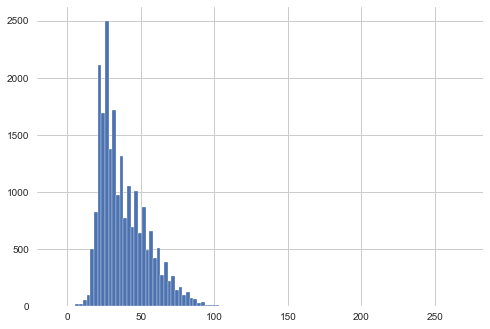

In [4]:
histograma_idade = df['age'].hist(bins=df['age'].nunique())

In [5]:
df = df[(df['age'] > 0) & (df['age'] <= 100)]

In [6]:
len(df[df['age'] > 100]), len(df[df['age'] < 0])

(0, 0)

### 2.2 Transfer learning

A técnica de _transfer learning_ é particularmente útil ao combinar modelos já validados em aplicações mais robustas, resultado de competições de grande porte.

Um benchmark nesse campo aplicado a faces é o [VGGFace](http://www.robots.ox.ac.uk/~vgg/data/vgg_face) do grupo *VGG*, o Visual Geometry Group da Univerdade de Oxford.

A arquitetura proposta pelo VGGFace é capaz de classificar faces com precisão acima de 90% em alguns trabalhos, como por exemplo [Zhang, Lingfeng & Kakadiaris, Ioannis. (2017). Local classifier chains for deep face recognition. 158-167](https://www.researchgate.net/publication/322872468_Local_classifier_chains_for_deep_face_recognition).

Este modelo tem a seguinte arquitetura.

<p align="center">
<img src="imagens-aux/vgg-face-architecture.jpg">
</p>

Observando a primeira camada, precisamos portanto padronizar as imagens de treinamento no tamanho 224 x 224 (comprimento x largura).

### 2.3 Padronização de imagens

O algoritmo abaixo normaliza as imagens para o tamanho de entrada do modelo VGGFace e também converte o valor em intenside de pixel de 0 a 255 para 0 a 1, com valores em pontos flutuantes.

Valores em ponto flutuante são melhores para se trabalhar com convergência de modelos durante os cálculos entre as camadas das redes neurais.

In [7]:
tamanho_imagem = (224, 224)
faces = []

for index, row in df.iterrows():
    image_face = image.load_img("imagens/%s" % ast.literal_eval(row["full_path"])[0], grayscale=False, target_size=tamanho_imagem)
    image_array = image.img_to_array(image_face).reshape(1, -1)[0]
    image_array /= 255
    faces.append(image_array)

In [10]:
qtd_faces = len(faces)

In [11]:
print("O total de faces de imagens é de " + str(qtd_faces) + ".")

O total de faces de imagens é de 22138.


### 2.4 Definição do modelo

O próximo passo é a definição do número de classes. Como a definição de classes é _zero based_ sempre defina adicionando 1 ao valor final.

Exemplo, se o número de classes compreender entre idades maior do que 0 e menor ou igual a 100, teremos 100 classes, logo o número de classes de idade é 101.

In [12]:
classes_idade = 101

Uma forma de categorizarmos as classes é utilizando o modelo _one hot encode_. Onde será expressado em um array com todas as classes. A classe correspondente a um determindo registro será armazenado como o valor 1 naquela classe.

In [13]:
idades = df['age'].values
idades_classes = keras.utils.to_categorical(idades, classes_idade)

Faça um teste do _one hot encoding_. Exiba os dados do registro de índice zero do conjunto de dados.

In [14]:
idades_classes[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Em seguida, vamos adaptar o _shape_ dos dados no padrão que o framework Keras utiliza.

In [15]:
features_imagem = []

features_imagem = np.array(faces)
features_imagem = features_imagem.reshape(features_imagem.shape[0], 224, 224, 3)

### 2.5 Separação de dados de treinamento e validação

Para que o modelo seja robusto, é importante validar um subconjunto de amostras que não participaram do treinamento inicial.

In [16]:
porcentagem_validacao = 0.3

Execute o método ```train_test_split``` para realizar a divisão de cada tipo de amostra, sendo:
* ```treinamento_x``` contém os _features_ de treinamento
* ```teste_x``` contém os _features_ de validação (também é chamado de teste)
* ```treinamento_y``` contém as classes de treinamento
* ```teste_y``` contém as classes de validação

In [17]:
treinamento_x, teste_x, treinamento_y, teste_y = train_test_split(features_imagem, idades_classes, test_size=porcentagem_validacao)

### 2.6 Treinamento e validação

O modelo VGGFace ainda não está por padrão na biblioteca Keras. Mesmo assim, como o artigo citado anteriormente possui a arquitetura definida, podemos implementá-la manualmente.

In [18]:
#VGG-Face model
modelo = Sequential()
modelo.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
modelo.add(Convolution2D(64, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(128, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(128, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(256, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(256, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(256, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(ZeroPadding2D((1,1)))
modelo.add(Convolution2D(512, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2), strides=(2,2)))
 
modelo.add(Convolution2D(4096, (7, 7), activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Convolution2D(4096, (1, 1), activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Convolution2D(2622, (1, 1)))
modelo.add(Flatten())
modelo.add(Activation('softmax'))

In [19]:
modelo.load_weights("pesos/vgg_face_weights.h5")

Assim como em qualquer modelo de _transfer learning_, precisamos adicionar na última camada as classes correspondentes. Deste modo, na saída da camada convulacional precisamos definir o número de classes. É o primeiro parâmetro do objeto ```Convolution2D```.

In [20]:
for layer in modelo.layers[:-7]:
    layer.trainable = False

saida_modelo = Sequential()

saida_modelo = Convolution2D(classes_idade, (1, 1), name='predictions')(modelo.layers[-4].output)

saida_modelo = Flatten()(saida_modelo)
saida_modelo = Activation('softmax')(saida_modelo)
modelo_idade = Model(inputs=modelo.input, outputs=saida_modelo)

Este tipo de treinamento possui muitas imagens. A etapa de treinamento pode demorar até mesmo mais do que 2 horas dependendo do tipo de computador utilizado.

Apesar da demora, este desafio traz um desafio real de treinar um modelo de imagens com quantidade de exemplos adequado para as classificações requeridas.

Sugiro que após o treinamento ser realizado, salvar os novos pesos e a rede para utilizar mais adiante nas inferências.

Revise a arquitetura da rede com o comando a seguir.

In [21]:
modelo_idade.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1_input (Inpu (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0   

O número de *épocas* é responsável por quantas vezes o modelo percorrerá o ciclo de _foward_ e _back_ _propagation_.

Como este modelo possui muitas imagens, sugerimos um valor mínimo de 2 épocas.

In [22]:
numero_epocas = 5

*Caso o modelo trave no treinamento, experimente diminuir o ```batch_size```.*

In [23]:
modelo_idade.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historico = modelo_idade.fit(x=treinamento_x, y=treinamento_y, validation_data=(teste_x, teste_y), epochs=numero_epocas, batch_size=32)

Train on 15496 samples, validate on 6642 samples
Epoch 1/5
15496/15496 [==============================] - 13994s 903ms/step - loss: 3.7428 - accuracy: 0.0491 - val_loss: 3.5292 - val_accuracy: 0.0613
Epoch 2/5
15496/15496 [==============================] - 13841s 893ms/step - loss: 3.5981 - accuracy: 0.0572 - val_loss: 3.5095 - val_accuracy: 0.0536
Epoch 3/5
15496/15496 [==============================] - 13839s 893ms/step - loss: 3.5347 - accuracy: 0.0619 - val_loss: 3.4680 - val_accuracy: 0.0632
Epoch 4/5
15496/15496 [==============================] - 13829s 892ms/step - loss: 3.4385 - accuracy: 0.0773 - val_loss: 3.4935 - val_accuracy: 0.0556
Epoch 5/5
15496/15496 [==============================] - 13874s 895ms/step - loss: 3.3855 - accuracy: 0.0887 - val_loss: 3.4546 - val_accuracy: 0.0578


In [24]:
# Salvando o modelo no formato HDf5
modelo_idade.save("modelos/modelo_idade.h5")
modelo_idade.save_weights("pesos/modelo_idade_pesos.h5")

Os valores de erro e acurácia são importantes indicadores de desempenho da rede. Avaliar a tendência de subida ou descida destes parâmetros é essencial para localizar, por exemplo, prooblemas de _overfitting_ e _underfitting_. 
Com o suporte dos gráficos avalie a tendência do modelo ao logo das épocas.

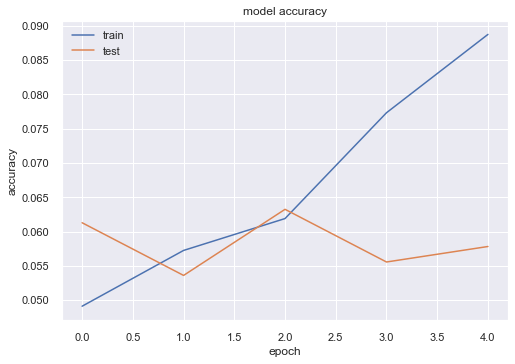

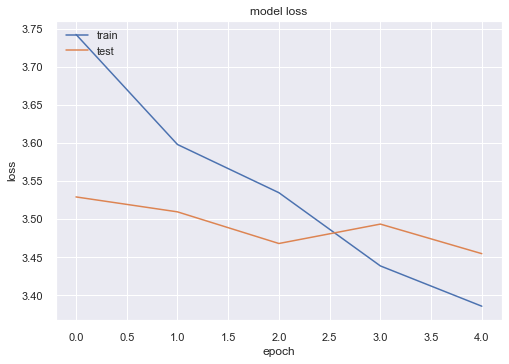

In [28]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Pergunta:** Qual foi a tendência da função de erro e acurácia do modelo?

**Resposta:**

Os comandos abaixo são de referência para carregar um modelo para inferências futuras.

In [29]:
# carregando o modelo no formato HDf5
modelo_idade = load_model("modelos/modelo_idade.h5")  
modelo_idade.load_weights("pesos/modelo_idade_pesos.h5")

Este classificador tem uma particularidade diferente quando comparado com outros classificadores.
Geralmente um classificador retorna, dado uma amostra, qual a classe mais próxima ou qual tem maior probabilidade estatística. Por exemplo, se fóssemos classificar um objeto, o retorno seria a classe correspondente àquele objeto com maior semelhança, mutualmente excludente, sendo uma única classe como resultado.

Neste caso é diferente.

Cada classe se refere a uma idade, logo, ao invés de nos basearmos na classe dominante, com maior probabilidade, podemos somar as probabilidades com cada classe e assim ter um valor de idade mais aproximado (veja na imagem abaixo do pipeline, item 5). 

É por essa razão que a acurácia do modelo, baseada somente na classe dominante é baixa.

<p align="center">
<img src="imagens-aux/pipeline.png">
</p>

Os comandos abaixo contabilizam a predição baseada na soma das probabilidades de cada classe.

In [ ]:
predicoes_idade = modelo_idade.predict(teste_x)
classes_idade_saida = np.array([i for i in range(0, classes_idade)])
predicoes_agrupadas = np.sum(predicoes_idade * classes_idade_saida, axis = 1)

Deste modo, o valor da acurácia não é o melhor para avaliarmoso modelo. A uma outra forma de avaliação é utilizarmos o _Erro Médio Absoluto_.

O uso do _Erro Médio Absoluto_ foi integralmente aplicado de acordo com este [artigo](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras).

In [ ]:
erro_medio_absoluto = 0
atual_media = 0

for i in range(0 ,predicoes_agrupadas.shape[0]):
    predicao = int(predicoes_agrupadas[i])
    atual = np.argmax(teste_y[i])
    erro_abs = abs(predicao - atual)
    atual_media = atual_media + atual
    erro_medio_absoluto += erro_abs

In [ ]:
erro_medio_absoluto /= predicoes_agrupadas.shape[0]
 
print("Erro médio absoluto (+/-): ", erro_medio_absoluto, " anos")
print("Exemplos analisados: ",predicoes_agrupadas.shape[0])

> **Critério de sucesso:** com base nas amostras de teste, o erro absoluto precisa ser não mais do que (+/-) 8.

### 2.7 Avaliação final

Vamos analisar um conjunto de 6 imagens e verificar a coerência do modelo.
Antes precisamos contruir uma função, a ```carregarImagem``` para padronizar a imagem, redimensionando para o formato do modelo e normalizando a intensidade dos pixels.

In [ ]:
def carregarImagem(caminho):
    imagem = image.load_img(caminho, target_size=(224, 224))
    imagem = image.img_to_array(imagem)
    imagem = np.expand_dims(imagem, axis = 0)
    imagem /= 255
    return imagem

Para cada imagem de testes já separadas no diretório ```testes```, vamos padronizá-la.

In [ ]:
caminho_imagem_1 = "testes/teste-1.jpg"
imagem_1_pad = carregarImagem(caminho_imagem_1)

Executar a inferência para obter sua predição.

In [ ]:
predicao_1 = modelo_idade.predict(imagem_1_pad)

E, finalmente, somar as classes para a classificação mais exata.

In [ ]:
idade_agrupada_1 = np.round(np.sum(predicao_1 * classes_idade_saida, axis = 1))

A função abaixo é para exibirmos no gráfico. Como elas estão com tamanhos diferentes, vamos também redimensioná-las para o padrão do moodeo, apenas por convenção, poderia ser outro tamanho.

In [ ]:
imagem_1 = image.load_img(caminho_imagem_1, target_size=(224, 224))

Agora, faremos para todas as outras imagens.

In [ ]:
caminho_imagem_2 = "testes/teste-2.png"
imagem_2_pad = carregarImagem(caminho_imagem_2)
imagem_2 = image.load_img(caminho_imagem_2, target_size=(224, 224))
predicao_2 = modelo_idade.predict(imagem_2_pad)
idade_agrupada_2 = np.round(np.sum(predicao_2 * classes_idade_saida, axis = 1))

caminho_imagem_3 = "testes/teste-3.png"
imagem_3_pad = carregarImagem(caminho_imagem_3)
imagem_3 = image.load_img(caminho_imagem_3, target_size=(224, 224))
predicao_3 = modelo_idade.predict(imagem_3_pad)
idade_agrupada_3 = np.round(np.sum(predicao_3 * classes_idade_saida, axis = 1))

caminho_imagem_4 = "testes/teste-4.png"
imagem_4_pad = carregarImagem(caminho_imagem_4)
imagem_4 = image.load_img(caminho_imagem_4, target_size=(224, 224))
predicao_4 = modelo_idade.predict(imagem_4_pad)
idade_agrupada_4 = np.round(np.sum(predicao_4 * classes_idade_saida, axis = 1))

caminho_imagem_5 = "testes/teste-5.png"
imagem_5_pad = carregarImagem(caminho_imagem_5)
imagem_5 = image.load_img(caminho_imagem_5, target_size=(224, 224))
predicao_5 = modelo_idade.predict(imagem_5_pad)
idade_agrupada_5 = np.round(np.sum(predicao_5 * classes_idade_saida, axis = 1))

caminho_imagem_6 = "testes/teste-6.png"
imagem_6_pad = carregarImagem(caminho_imagem_6)
imagem_6 = image.load_img(caminho_imagem_6, target_size=(224, 224))
predicao_6 = modelo_idade.predict(imagem_6_pad)
idade_agrupada_6 = np.round(np.sum(predicao_6 * classes_idade_saida, axis = 1))

Exibindo as imagens.

O resultado da idade é índice 0 do objeto ```idade_agrupada```.

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(231)
plt.title("Idade inferida " + str(idade_agrupada_1[0]))
plt.imshow(imagem_1)
plt.subplot(232)
plt.title("Idade inferida " + str(idade_agrupada_2[0]))
plt.imshow(imagem_2)
plt.subplot(233)
plt.title("Idade inferida " + str(idade_agrupada_3[0]))
plt.imshow(imagem_3)
plt.subplot(234)
plt.title("Idade inferida " + str(idade_agrupada_4[0]))
plt.imshow(imagem_4)
plt.subplot(235)
plt.title("Idade inferida " + str(idade_agrupada_5[0]))
plt.imshow(imagem_5)
plt.subplot(236)
plt.title("Idade inferida " + str(idade_agrupada_6[0]))
plt.imshow(imagem_6)

plt.show()

Analise se as idades estão coerentes com as imagens. Se estiver muito fora, avalie aumentar o número de épocas, por exemplo.

Agora vamos implementar a função que retornará a idade a partir de uma imagem de entrada já padronizada (assuma que foi padronizada por uma função como a ```carregarImagem```. Assegure que a função retorne o valor da idade inferida em valor numérico, sem valor fracionário, somente inteiro.

In [ ]:
def predizerIdade(imagem):
    # IMPLEMENTAR

## 3. Modelo de predição de gênero biológico

A base utilizada será a mesma que aplicamos no modeo de idade. Nesse o caso o modelo terá uma tarefa mais fácil, pois ao invés de aproximidamente 100 classes vamos ter somente 2 classes, uma cada definir o gênero masculino e outra para o gênero feminino. 

### 3.1 Definição do modelo
Vamos começar definindo o número de classes.

In [ ]:
# IMPLEMENTAR
num_classes_genero = None

Transformando os valores do conjunto de dados em _one hot enconding_ para definição dos gêneros.

In [ ]:
generos = df['gender'].values
generos_classes = keras.utils.to_categorical(generos, num_classes_genero)

Como para ambos os modelos, de idade e gênero, utilizamos a mesma base de _transfer learning_ do VGGFace, vamos reutilizá-la também neste modelo.

In [ ]:
for layer in modelo.layers[:-7]:
    layer.trainable = False

saida_modelo = Sequential()
saida_modelo = Convolution2D(num_classes_genero, (1, 1), name='predictions')(modelo.layers[-4].output)
saida_modelo = Flatten()(saida_modelo)
saida_modelo = Activation('softmax')(saida_modelo)

modelo_genero = Model(inputs=modelo.input, outputs=saida_modelo)

### 3.2 Separação de dados de treinamento e validação

É recomendavel manter a mesma porcentagem do modelo anterior para dividir os dados de treinamento e validação.

In [ ]:
#IMPLEMENTAR
porcentagem_validacao = None

In [ ]:
treinamento_x, teste_x, treinamento_y, teste_y = train_test_split(features_imagem, 
                                                                  generos_classes, 
                                                                  test_size=porcentagem_validacao)

### 3.3 Treinamento e validação

A seguir iremos treinar o modelo para classificação de gêneros.
De forma semelhante realizada anteriormente, é necessário definir o número de épocas para esta etapa. Recomendamos um valor mínimo de 2.

In [ ]:
# IMPLEMENTAR
numero_epocas = None

*Caso o modelo trave no treinamento, experimente diminuir o ```batch_size```*.

Este modelo é mais simples por ter menos classes, logo podemos assumir um ```batch_size``` maior que o anterior.

In [ ]:
modelo_genero.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historico_genero = modelo_genero.fit(x=treinamento_x, y=treinamento_y, 
                             validation_data=(teste_x, teste_y), epochs=numero_epocas, batch_size=64)

Verifique abaixo, por meio dos gráficos, como está a evolução da função de erro e acurácia do modelo.

In [ ]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(historico_genero.history['acc'])
plt.plot(historico_genero.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(historico_genero.history['loss'])
plt.plot(historico_genero.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Pergunta:** Qual foi a tendência da função de erro e acurácia do modelo?

**Resposta:**

Salve os modelos abaixo para uso em inferências mais adiante no projeto.

In [ ]:
# Salvando o modelo no formato HDf5
modelo_genero.save("modelos/modelo_genero.h5")
modelo_genero.save_weights("pesos/modelo_genero_pesos.h5")

Os comandos a seguir são para carregar os pesos e o modelo previamente treinado.

In [ ]:
# carregando o modelo no formato HDf5
modelo_genero = load_model("modelos/modelo_genero.h5")  
modelo_genero.load_weights("pesos/modelo_genero_pesos.h5")

> **Critério de sucesso:** acurácia do modelo, com base nas amostra de teste, superior a 95%.

### 3.4 Avaliação final

Com base em algumas amostras da base de testes, vamos inferir 6 imagens para verificarmos o desempenho do modeo.
Selecionamos 3 imagens de homens e mulheres.

Como este modelo é mais simples, ou seja, o resultado sempre vai ser a classe com maior probabilidade, não precisamos realizar a somatória dos pesos individualmente como fizemos no modelo anterior.

Assim o resultado final será obtido pela maior classe. A função ```np.argmax``` retorna a maior classe da predição realizada pelo modelo.

De acordo com o _encoding_, o índice 0 indica gênero masculino e o índice 1 o gênero feminino.

In [ ]:
predicao_1 = modelo_genero.predict(imagem_1_pad)
resultado_1 = "Masculino" if np.argmax(predicao_1) == 1 else "Feminino"

predicao_2 = modelo_genero.predict(imagem_2_pad)
resultado_2 = "Masculino" if np.argmax(predicao_2) == 1 else "Feminino"

predicao_3 = modelo_genero.predict(imagem_3_pad)
resultado_3 = "Masculino" if np.argmax(predicao_3) == 1 else "Feminino"

predicao_4 = modelo_genero.predict(imagem_4_pad)
resultado_4 = "Masculino" if np.argmax(predicao_4) == 1 else "Feminino"

predicao_5 = modelo_genero.predict(imagem_5_pad)
resultado_5 = "Masculino" if np.argmax(predicao_5) == 1 else "Feminino"

predicao_6 = modelo_genero.predict(imagem_6_pad)
resultado_6 = "Masculino" if np.argmax(predicao_6) == 1 else "Feminino"

Agora vamos exibir no gráfico as imagens e as inferências realizadas.

In [ ]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

plt.figure(figsize=(20,10))
plt.subplot(231)
plt.title("Gênero inferido: " + resultado_1)
plt.imshow(imagem_1)
plt.subplot(232)
plt.title("Gênero inferido: " + resultado_2)
plt.imshow(imagem_2)
plt.subplot(233)
plt.title("Gênero inferido: " + resultado_3)
plt.imshow(imagem_3)
plt.subplot(234)
plt.title("Gênero inferido: " + resultado_4)
plt.imshow(imagem_4)
plt.subplot(235)
plt.title("Gênero inferido: " + resultado_5)
plt.imshow(imagem_5)
plt.subplot(236)
plt.title("Gênero inferido: " + resultado_6)
plt.imshow(imagem_6)

plt.show()

Vamos aproveitar para deixar preparado a função de predição de gênero para usarmos mais adiante.
Implemente a função abaixo para retornar "Masculino" se a classe com maior probabilidade for 1, ou "Feminino" se a maior probabilidade for a classe igual a 0.
É do mesmo jeito que fizemos anteriormente na predição de idade. Assuma que o parâmetro de entrada seja uma imagem já padronizada.

In [ ]:
def predizerGenero(imagem):
    # IMPLEMENTAR

## 4. Identificação de faces

Nesta etapa precisamos construir uma forma de extrair regiões de interesse de imagens que sejam rostos. 
Problema de reconhecimento de faces aprofundado é realizada a partir de um recorte de região de interesse. Logo, nossa estratégia agora é como extrair uma ou mais faces de uma imagem para que seja possível, posteriormente, aplicarmos os modelos que acabamos de classificar.

Vamos começar com um teste simples.

In [ ]:
imagem = cv2.imread('testes/teste-8.png')
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.title("Pessoas")

Escolha uma forma de identificar rostos de uma imagem.
Recomendamos as seguintes formas:

* Classificador em cascata de Haar
* Detector de face baseado em Hog (DLib), recomendamos utilizar o classificador de 68 pontos para maior precisão

Dada a imagem de testes apresentada, execute seu algoritmo escolhido e retorne o número de faces na variável ```faces```.

In [ ]:
# IMPLEMENTAR

faces = None

In [ ]:
print("Faces encontradas: " + str(len(faces)))

> **Critério de sucesso:** encontrar as 2 faces da imagem.

Com as faces identificadas, desenhe um retângulo em cada uma delas.
Para desenhar um retângulo, é necessário os seguintes dados: coordenada x, y, comprimento (w) e altura (h).

Caso utilize o detector de faces do DLib, o valor da coordenada x é equivalente ao atributo _left_ e a coordenada y é o equivalente ao atributo _top_.

O DLib é um identificador tão versátil que é capaz de identificar rostos parciais em uma imagem. No entanto, quando isso ocorre as coordenadas podem ser negativas, o que pode demandar um certo ajuste para obter o valor da região de interesse, por exemplo igualando a coordenada a 0.

Utilize o seguinte comando para desenhar um retângulo em cada face identificada.

````
cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)
````

Criando uma cópia da imagem original para anotação.

In [ ]:
imagem_anotada = imagem.copy()

In [ ]:
#IMPLEMENTAR


Exibindo a imagem com os retângulos desenhados.

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Pessoas")

Uma vez que já foi definido o melhor algoritmo de identificação de faces, precisamos construir uma função que posteriormente utilizaremos no processo de processamento de vídeos.

Essa função deverá receber na entrada uma imagem colorida e retornar, na forma de lista, um dicionário com as seguintes informações: extração do ROI do rosto e as coordenadas da localização do rosto.

Exemplo de retorno:

```json
[{'coordenadas': [array([589, 290, 386, 386])],
  'rosto': array([[[38, 21, 19],
          [40, 21, 20],
          [41, 22, 20],
          ...,
          [36, 19, 13],
          [37, 20, 15],
          [40, 23, 18]],...}]
```

O atributo rosto utilizaremos para aplicarmos os modelos de reconhecimento de idade e gênero, e as coordenadas serão utilizadas para fazer os recortes nas imagens.

Com isso, a chave ```rosto``` deverá ter o _slice_ da imagem neste padrão ```imagem[y:y+h, x:x+w]``` e a chave ```coordenadas``` deverá ter a saída dos pontos (x, y, h, w) neste padrão ```[np.array(lista_coordenadas)]```.

In [ ]:
def obterFaces(imagem):
    rostos = []
    
    #IMPLEMENTAR
    
    return rostos

Vamos aplicar um teste com a imagem anterior (variável ```imagem```).

In [ ]:
rostos = obterFaces(imagem)
rostos

> **Critério de sucesso:** retornar 2 valores (da lista) com coordenadas e rosto para cada face identificada. Exemplo:


```
[{'coordenadas': [array([534, 20,  90, 100], dtype=int32)],
  'rosto': array([...], shape=(0, 89, 3), dtype=uint8)},
  {'coordenadas': [array([222, 13,  90, 100], dtype=int32)],
  'rosto': array([...], shape=(0, 89, 3), dtype=uint8)}]
```

Agora vamos testar se os parâmetros estão funcionando adequadamente.

Primeiro a imagem do rosto.

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(20,10))
plt.imshow(rostos[0]["rosto"])
plt.title("Pessoas")

O próximo passo são as coordenadas. Para simplificar, vamos desenhar um retângulo na imagem original com estes pontos.

In [ ]:
imagem_anotada = imagem.copy()

for (x,y,w,h) in rostos[0]["coordenadas"]:
    cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)

sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Pessoas")

### 4.1 Padronização de tamanho de imagem

Adiante, quando aplicarmos a classificação dos rostos, precisaremos antes padronizar a imagem para o tamanho que o modelo recebe na camada de entrada bem como a normalização dos pixels da imagem, ou seja, ao invés de estar no formato de intensidade de pixel de 0 a 255, deve estar representado entre 0 e 1.

As implementações deverão ser as seguintes:

1. ```IMPLEMENTAR 1```: redimensionar a imagem para o tamanho da camada de entrada. Utilize uma interpolação adequada para não perder qualidade de imagem.
2. ```IMPLEMENTAR 2```: normalizar a intensidade de pixel da imagem para 0 e 1 e não 0 a 255, que é o padrão.

As demais instruções seguem inalteradas.

In [ ]:
def padronizarROI(imagem):
    # IMPLEMENTAR 1
    imagem = None
    
    imagem = image.img_to_array(imagem)
    imagem = np.expand_dims(imagem, axis = 0)
    
    # IMPLEMENTAR 2
    imagem = None
    
    return imagem

Agora, vamos avançar para a identificação de objetos.

## 5. Identificação de objetos

Além de identificarmos as pessoas, precisamos também identificar diferentes objetos.
Uma forma de alcançarmos tal objetivo é utilizar um modelo já treinado com diversos objetos treinados.

O modolo Yolov3, por exemplo, possui 80 diferentes objetos em seu modelo, servindo muito bem para o propósito do desafio.

### 5.1 Configurando o modelo Yolov3

Primeiramente baixe os pesos diretamente no site do Darknet, neste [link](https://pjreddie.com/media/files/yolov3.weights). Copie o arquivo ```yolov3.weights``` para a pasta pesos.
Confira o arquivo ```yolo-classes/coco.anmes```. Estas são as classes de todos os objetos que são possíveis identificar.
Por fim, verifique se o arquivo ```config/yolov3.cfg``` está presente. Não é necessário ajustar nenhum parâmetro nele.

In [ ]:
# Carregar os labels do conjunto de dados Coco
label_path = "yolo-classes/coco.names"
labels = open(label_path).read().strip().split("\n")

# Atribuir a cada label uma cor diferente (randômica)
np.random.seed(42)
cores = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

# Definir caminho dos arquivos de pesos e configuração
pesos_path ="pesos/yolov3.weights"
config_path = "config/yolov3.cfg"

# Carregar a rede
net = cv2.dnn.readNetFromDarknet(config_path, pesos_path)

Se o código carregou as configurações sem erros, estamos prontos para avançar.

Os valores de confiança e supressão não máxima são atributes importantes para o processo de detecção de objetos. Escolha valores adequados que permitam a detecção aceitável e com valores próximos os critérios de sucesso apresentandos mais adiante.

Os valores precisam ser numéricos fracionários. Sendo que 1 é igual a 100%. Valores médios costumam apresentar performance razoável.

In [ ]:
conf_threshold = None
nms_threshold = None

**Pergunta:** Qual é a influência do parâmetro de confiança e supressão não máxima na performance do modelo?

**Resposta:**

### 5.2 Obtendo região de interesse e coordenadas

De forma semelhante que foi feito na identificação de faces, vamos fazer para a identificação de objetos.
Na função abaixo vamos implementar um algoritmo que retornará em um dicionário os valores do recorte da imagem, o que chamamos de região de interesse e suas coordenadas x, y, w e h.

A entrada da função é uma imagem colorida e uma lista de objetos para identificar, no formato de lista.
Sua saída, é uma lista de objetos no seguinte formato:

```json
[{'coordenadas': [array([589, 290, 386, 386])],
  'objeto': array([[[38, 21, 19],
          [40, 21, 20],
          [41, 22, 20],
          ...,
          [36, 19, 13],
          [37, 20, 15],
          [40, 23, 18]],...}]
```

Onde ```coordenadas``` é uma lista das coordenadas x, y, w e h no formato array, igual ao que foi apresentado anteriormente: ```[np.array(lista_coordenadas)]```. E ```objeto``` é a região de interesse do objeto extraído, igual ao que foi apresentado anteriormente: ```imagem[y:y+h, x:x+w]```.

In [ ]:
def obter_objetos(imagem, lista_objetos):
    
    (H, W) = imagem.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(imagem, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    boxes = []
    confidences = []
    classIDs = []
    objetos = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > conf_threshold:
                
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width/2))
                y = int(centerY - (height/2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            if x < 0:
                x = 0
            if y < 0:
                y = 0

            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            
            if labels[classIDs[i]] in lista_objetos:
                print("Identificado " + text)
                
                # IMPLEMENTAR
                item = {"objeto": None, "coordenadas": None}
                
                objetos.append(item)

    return objetos

Vamos utilizar outra imagem de testes para validar o algoritmo.

In [ ]:
imagem_inferencia = cv2.imread("testes/teste-9.png")
imagem_inferencia = cv2.cvtColor(imagem_inferencia, cv2.COLOR_BGR2RGB)

Na variável ```lista_objetos``` preecha com uma lista de Strings com os valores "pessoa" e "gravata" que são os objetos a serem identificados.

In [ ]:
# IMPLEMENTAR
lista_objetos = ["pessoa", "gravata"]

Execute a função com a lista definida.

In [ ]:
objetos = obter_objetos(imagem_inferencia, lista_objetos)

Para nos certificamos que a identificação está correta, vamos desenhar um retângulo delimitador na imagem e verificar como foi a identificação.

Neste caso vamos utilizar o parâmetro ```coordenadas``` do retorno da função para cada objeto identificado.

In [ ]:
imagem_anotada = imagem_inferencia.copy()
for obj in objetos:
    for (x,y,w,h) in obj["coordenadas"]:
        cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Imagem Inferida")

Vamos dar uma olhada em 3 regiões de interesse detectadas.
Lembrando que estas regiões são imagens, podemos renderizá-las diretamente no Pyplot.

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[0]["objeto"])
plt.title("Região de interesse #1")

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[1]["objeto"])
plt.title("Região de interesse #1")

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[2]["objeto"])
plt.title("Região de interesse #1")

Perfeito, agora já estamos prontos para juntar todas as peças e começar nossa auditoria.

## 6. Auditoria automática em vídeo

Esta é a parte final do projeto.
Vamos fazer um checkpoint até aqui para ter certeza de que fizemos com sucesso os passos anteriores.

* <input type="checkbox" disabled checked> Modelo de detecção de idades treinado
* <input type="checkbox" disabled checked> Modelo de detecção de idades salvo
* <input type="checkbox" disabled checked> Modelo de detecção de idades carregado
* <input type="checkbox" disabled checked> Função de detecção de idades
* <input type="checkbox" disabled checked> Modelo de detecção de gênero treinado
* <input type="checkbox" disabled checked> Modelo de detecção de gênero salvo
* <input type="checkbox" disabled checked> Modelo de detecção de gênero carregado
* <input type="checkbox" disabled checked> Função de detecção de gênero
* <input type="checkbox" disabled checked> Função de padronização de imagens
* <input type="checkbox" disabled checked> Função de extração de faces
* <input type="checkbox" disabled checked> Função de extração de objetos

O que precisamos identificar no vídeo de auditoria:

* Homens com mais de 45 anos
* Mulheres com menos de 45 anos
* Objetos _computador portátil, celular, teclado, tv _ e _controle remoto_.

Vamos começar definindo a lista de objetos.

In [ ]:
lista_objetos = [None]

Nesta parte vamos reunir tudo o que fizemos até aqui.
O algoritmo irá abrir um vídeo e, frame a frame, analisar seu conteúdo.
Após a instrução ```if is_capturing``` iremos implementar as verificações.

A execução abaixo pode demorar, pois será analisado individualmente cada frame do vídeo.

O que precisamos fazer:

* ```IMPLEMENTAR 1```: obter as faces de uma imagem. Neste caso receberamos uma lista de rostos no padrão que já vimos, ou seja, uma lista de ```rosto``` e ```coordenadas```.

* ```IMPLEMENTAR 2```: obter as a face de um item e padronizar. Lembre-se de utilizar a função de padronização que foi desenvolvida anteriormente, que tem por finalidade ajustar o tamanho da imagem e também normalizá-la.

* ```IMPLEMENTAR 3```: executar as funções de identificar a idade e gênero para a tomada de decisões de coleta de evidências.

* ```IMPLEMENTAR 4```: criar as regras de armazenamento de evidências para pessoas. Consulte as regras no início do projeto sobre quais os gêneros e idades de interesse. As regiões de interesse nesse caso, os rostos, deverão ser salvos individualmente na pasta ```resultado/homem``` e ```resultado/mulher```.

* ```IMPLEMENTAR 5```: criar as regras de armazenamento de evidências para objetos. As regiões de interesse nesse caso, os objetos, deverão ser salvos individualmente na pasta ```resultado/objetos```.

In [ ]:
#cam.release()
cam = cv2.VideoCapture("videos/video-1.avi")
contador = 0 
try:
    while(True):
        contador += 1
        is_capturing, imagem = cam.read()
        
        if is_capturing:
            
            # IMPLEMENTAR 1
            # Obter Faces
            faces = None
            
            for idx, face in enumerate(faces):
                print("Encontrado " + str(len(faces)) + " rostos...")
                
                # IMPLEMENTAR 2
                # Padronizar a imagem do rosto (ROI)
                # Obtenha a imagem do rosto da variável face e armazene em imagem_rosto
                # Depois utilize a função padronizarROI, com a variável imagem_rosto para obter
                # o rosto padronizado e armazenar em rosto_padronizado
                
                imagem_rosto = None
                rosto_padronizado = None
                
                # IMPLEMENTAR 3
                # Chame as funções para predizer gênero e idade com a imagem padronizada do rosto
                
                genero = None
                idade = None
                
                print("Gênero: " + genero + ", idade: " + str(idade))
                
                # IMPLEMENTAR 4
                # Estabeleça as regras de auditoria e salve as evidências (imagens) no diretório resultados
                # de acordo com o identificação (resultado/homem, resultado/mulher)
                # Cuidado para não sobrescrever as imagens
                
                if (True):
                 
                    
            objetos = obter_objetos(imagem, lista_objetos)

            # IMPLEMENTAR 5
            # Estabeleça as regras de auditoria e salve as evidências (imagens) no diretório resultados
            # de acordo com o identificação (resultado/objetos)
            # Cuidado para não sobrescrever as imagens
            
            if (True):
                    
        else:
            break
        
except KeyboardInterrupt:
    cam.release()
    print("Interrompido")

> **Critério de sucesso:** identificação de 180 imagens de homens. Como uma mesma pessoa aparece em diferentes frames é comum repetir as imagens.

> **Critério de sucesso:** identificação de 190 imagens de mulheres. Como uma mesma pessoa aparece em diferentes frames é comum repetir as imagens.

> **Critério de sucesso:** identificação de 680 imagens de objetos selecionados. Como um mesmo objeto pode aparecer em diferentes frames é comum repetir as imagens

## 7. Conclusões finais

Com base nesta jornada de construção de modelos, análises de regiões de interesse e processamento de vídeo, comente quais seriam os principais pontos de melhoria para alcançar resultados melhores em todas as etapas.

**Resposta: **